#Import Libraries

In [185]:
!pip install pyvis

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyvis.network import Network

In [187]:
# Connect google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets

In [188]:
artists = pd.read_csv("/content/drive/MyDrive/DS Mini Project/Project-3/artists.csv")
artists.sample(3)

,artistUrl,id,image,nation,title,totalWorksTitle,year
2223,/en/nicolae-maniu,57726dd2edc2cb3880b51205,https://uploads5.wikiart.org/temp/754b85c0-3b6...,Romanian,Nicolae Maniu,19 artworks,born 1944
162,/en/anton-melbye,57726dc4edc2cb3880b4fc44,https://uploads5.wikiart.org/temp/2afeb114-a5f...,NaN,Anton Melbye,16 artworks,1818 - 1875
2716,/en/cope2,57726defedc2cb3880b54057,https://uploads3.wikiart.org/images/cope2.jpg!...,American,Cope2,10 artworks,born 1968


In [189]:
inst = pd.read_csv("/content/drive/MyDrive/DS Mini Project/Project-3/institutions.csv")
inst.sample(3)

,city,country,title,url
22,Copenhagen,Denmark,Royal Danish Academy of Fine Arts,/en/artists-by-art-institution/royal-danish-ac...
54,Black Mountain,NC,Black Mountain College,/en/artists-by-art-institution/black-mountain
1,Antwerp,Belgium,Royal Academy of Fine Arts,/en/artists-by-art-institution/royal-academy-o...


In [190]:
rels = pd.read_csv("/content/drive/MyDrive/DS Mini Project/Project-3/relationships.csv")
rels.sample(3)

,artistUrl,friends,influenced_by,influenced_on,institution,movements,school,type
578,/en/andres-de-santa-maria,NaN,"/en/jean-francois-millet,/en/gustave-courbet",NaN,/en/artists-by-art-institution/cole-des-beaux-...,Impressionism,NaN,Artists
1391,/en/charles-alston,NaN,/en/amedeo-modigliani,NaN,/en/artists-by-art-institution/art-students-le...,Harlem Renaissance (New Negro Movement),NaN,Artists
2678,/en/karel-skreta,NaN,NaN,NaN,NaN,Baroque,NaN,Artists


In [191]:
schools = pd.read_csv("/content/drive/MyDrive/DS Mini Project/Project-3/schools.csv")
schools.sample(3)

,title,url
211,Swabian school,/en/artists-by-painting-school/swabian-school
94,Brandywine School,/en/artists-by-painting-school/brandywine-school
115,Utagawa school,/en/artists-by-painting-school/utagawa-school


# Step-1

## Data Preprocess

In [192]:
# Checking for missing values
print("\nMissing values in Artists Dataset:\n", artists.isnull().sum())
print("\nMissing values in Institutions Dataset:\n", inst.isnull().sum())
print("\nMissing values in Relationships Dataset:\n", rels.isnull().sum())
print("\nMissing values in Schools Dataset:\n", schools.isnull().sum())


Missing values in Artists Dataset:
 artistUrl           0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64

Missing values in Institutions Dataset:
 city       2
country    2
title      0
url        0
dtype: int64

Missing values in Relationships Dataset:
 artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institution      2362
movements          40
school           1966
type                1
dtype: int64

Missing values in Schools Dataset:
 title    0
url      0
dtype: int64


### Data Distribution

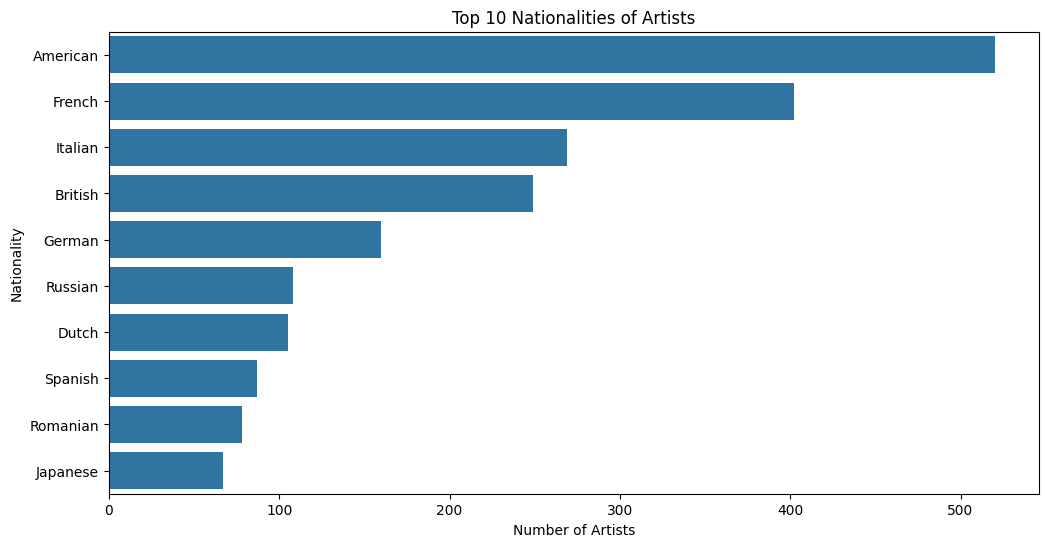

In [193]:
# Nationality distribution plot for artists
plt.figure(figsize=(12, 6))
sns.countplot(y='nation', data=artists, order=artists['nation'].value_counts().index[:10])
plt.title('Top 10 Nationalities of Artists')
plt.xlabel('Number of Artists')
plt.ylabel('Nationality')
plt.show()

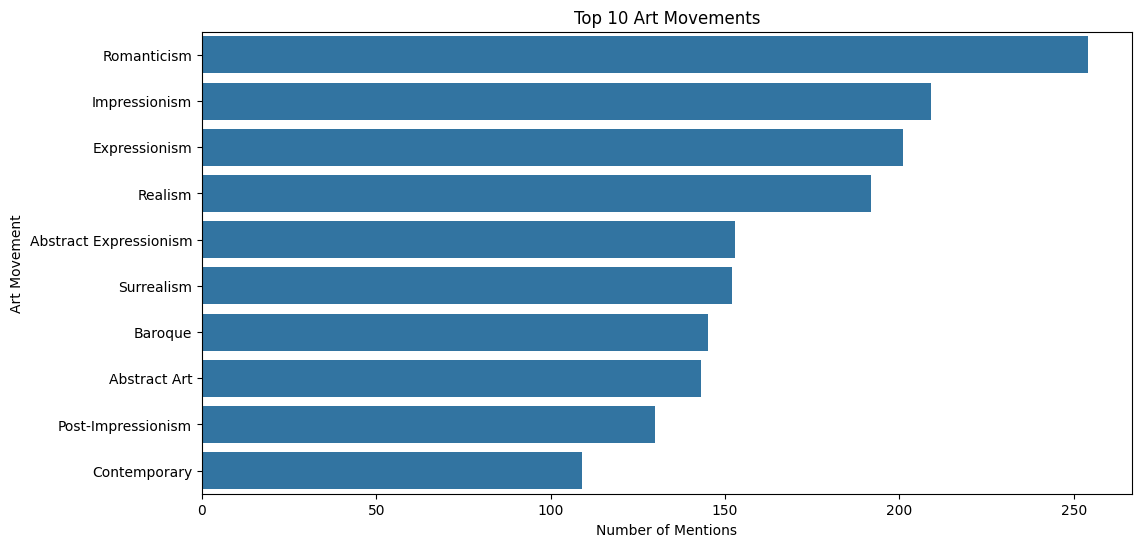

In [194]:
# Movements distribution in the relationships data
# Split movements if multiple movements are listed per artist
rels['movements_list'] = rels['movements'].str.split(',')

# Explode the movements to count them individually
movements_exploded = rels.explode('movements_list')

# Reset index to avoid duplicate labels
movements_exploded = movements_exploded.reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.countplot(y='movements_list', data=movements_exploded, order=movements_exploded['movements_list'].value_counts().index[:10])
plt.title('Top 10 Art Movements')
plt.xlabel('Number of Mentions')
plt.ylabel('Art Movement')
plt.show()

In [195]:
# Preview the column to see the data format
print(artists['totalWorksTitle'].head())

# Extract numeric values from the 'totalworkstitle' column
artists['totalWorksTitle'] = artists['totalWorksTitle'].str.extract('(\d+)').astype(float)

# Check the updated column
print(artists['totalWorksTitle'].head())

0    169 artworks
1     87 artworks
2     76 artworks
3      8 artworks
4     76 artworks
Name: totalWorksTitle, dtype: object
0    169.0
1     87.0
2     76.0
3      8.0
4     76.0
Name: totalWorksTitle, dtype: float64


<ipython-input-196-d64f133b2cfd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='totalWorksTitle', y='title', data=top_artists, palette="viridis")


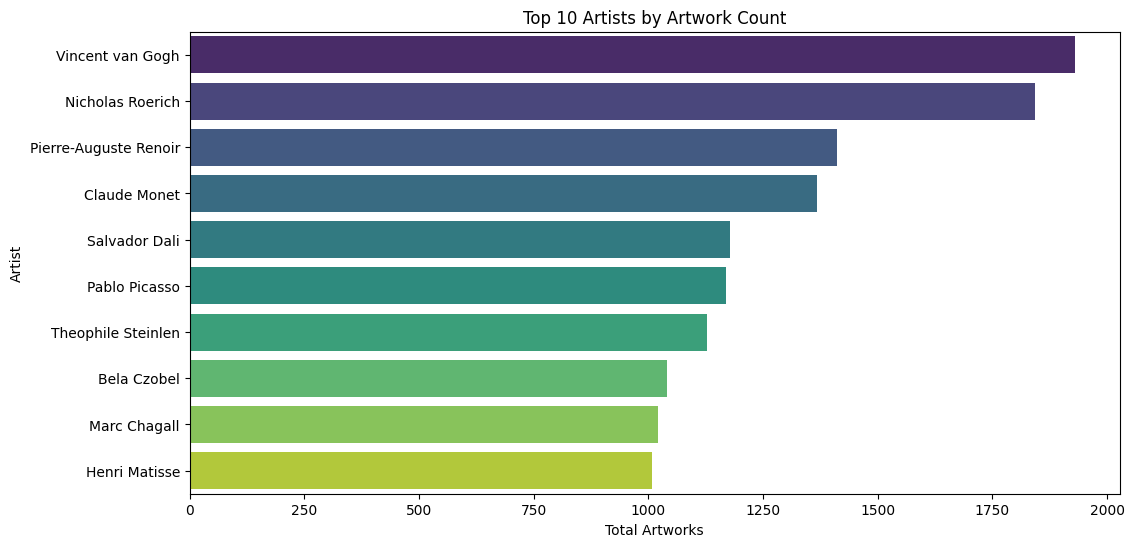

In [196]:
# Sort artists by artwork count to get top artists by production
top_artists = artists.sort_values(by='totalWorksTitle', ascending=False).head(10)

# Bar plot for top artists by artwork count
plt.figure(figsize=(12, 6))
sns.barplot(x='totalWorksTitle', y='title', data=top_artists, palette="viridis")
plt.title('Top 10 Artists by Artwork Count')
plt.xlabel('Total Artworks')
plt.ylabel('Artist')
plt.show()

## 1. Most Influential Artists

In [197]:
influenced_by = rels[['artistUrl', 'influenced_by']]
influenced_by = influenced_by.dropna()

influenced_on = rels[['artistUrl', 'influenced_on']]
influenced_on = influenced_on.dropna()

In [198]:
influenced_by.head(5)

,artistUrl,influenced_by
0,/en/apelles,/en/ancient-greek-painting
5,/en/ancient-greek-pottery,"/en/ancient-greek-painting,/en/ancient-egyptia..."
8,/en/fayum-portrait,"/en/ancient-greek-painting,/en/ancient-egyptia..."
18,/en/ambrogio-lorenzetti,"/en/simone-martini,/en/duccio,/en/giotto,/en/a..."
22,/en/orthodox-icons,"/en/byzantine-mosaics,/en/fayum-portrait"


In [200]:
influenced_on.head(5)

,artistUrl,influenced_on
0,/en/apelles,/en/ancient-greek-painting
2,/en/ancient-egyptian-painting,"/en/fayum-portrait,/en/ancient-greek-painting,..."
5,/en/ancient-greek-pottery,/en/ancient-greek-painting
8,/en/fayum-portrait,"/en/orthodox-icons,/en/artists-by-art-movement..."
13,/en/duccio,"/en/ambrogio-lorenzetti,/en/pietro-lorenzetti"


### Create Separate Rows for Multiple Artists in `influenced_on` & `influenced_by` Column

In [201]:
influenced_by['influenced_by'] = influenced_by['influenced_by'].str.split(',')
influenced_by = influenced_by.explode('influenced_by').reset_index(drop=True)
influenced_by.head(5)

,artistUrl,influenced_by
0,/en/apelles,/en/ancient-greek-painting
1,/en/ancient-greek-pottery,/en/ancient-greek-painting
2,/en/ancient-greek-pottery,/en/ancient-egyptian-painting
3,/en/fayum-portrait,/en/ancient-greek-painting
4,/en/fayum-portrait,/en/ancient-egyptian-painting


In [202]:
influenced_on['influenced_on'] = influenced_on['influenced_on'].str.split(',')
influenced_on = influenced_on.explode('influenced_on').reset_index(drop=True)
influenced_on.head(5)

,artistUrl,influenced_on
0,/en/apelles,/en/ancient-greek-painting
1,/en/ancient-egyptian-painting,/en/fayum-portrait
2,/en/ancient-egyptian-painting,/en/ancient-greek-painting
3,/en/ancient-egyptian-painting,/en/ancient-greek-pottery
4,/en/ancient-greek-pottery,/en/ancient-greek-painting


### Convert Artist URL to Names

In [203]:
url_to_title_mappings = artists.set_index('artistUrl')['title'].to_dict()

In [204]:
influenced_by = influenced_by.replace(url_to_title_mappings)
influenced_on = influenced_on.replace(url_to_title_mappings)

In [205]:
influenced_by.sample(5)

,artistUrl,influenced_by
1213,Théodore Géricault,John Singleton Copley
622,Eugene Delacroix,Antoine-Jean Gros
926,Gavin Hamilton,Anton Raphael Mengs
188,Claude Monet,J.M.W. Turner
708,Lee Krasner,Piet Mondrian


In [206]:
influenced_on.sample(5)

,artistUrl,influenced_on
96,Titian,Edgar Degas
1091,Peter Paul Rubens,Walter Osborne
223,Edouard Manet,Edgar Degas
611,Juan Gris,Balcomb Greene
469,John Marin,Charles E. Burchfield


### Remove Rows Without Artist Titles

In [207]:
influenced_by['artistUrl'] = influenced_by['artistUrl'].where(influenced_by['artistUrl'].isin(url_to_title_mappings.values()))
influenced_by['influenced_by'] = influenced_by['influenced_by'].where(influenced_by['influenced_by'].isin(url_to_title_mappings.values()))

In [208]:
influenced_by.dropna(inplace=True)

In [209]:
influenced_on['artistUrl'] = influenced_on['artistUrl'].where(influenced_on['artistUrl'].isin(url_to_title_mappings.values()))
influenced_on['influenced_on'] = influenced_on['influenced_on'].where(influenced_on['influenced_on'].isin(url_to_title_mappings.values()))

In [210]:
influenced_on.dropna(inplace=True)

In [211]:
influenced_by.sample(5)

,artistUrl,influenced_by
7,Ambrogio Lorenzetti,Giotto
202,Alfred Sisley,John Constable
519,L. S. Lowry,Balthus
240,Benjamin West,Anton Raphael Mengs
1082,Kara Walker,Otto Dix


In [212]:
influenced_on.sample(5)

,artistUrl,influenced_on
747,Mark Rothko,Michel Majerus
1070,Caravaggio,Francisco de Zurbaran
1092,Frans Hals,Judith Leyster
689,Camille Corot,Alfred Sisley
1109,Nicolas Poussin,Jean Hugo


## Visualization (Influential Artists)

Combine the dataframes to create edges (from artist to `influenced_by` or `influenced_on`). We will create a directed graph where sources will be the artists & destinations will be the artists they influence.

In [213]:
edges_by = influenced_by[['influenced_by', 'artistUrl']].rename(columns={'influenced_by': 'source', 'artistUrl': 'target'})
edges_on = influenced_on[['artistUrl', 'influenced_on']].rename(columns={'artistUrl': 'source', 'influenced_on': 'target'})
edges = pd.concat([edges_by, edges_on])
edges.sample(5)

,source,target
525,Pablo Picasso,Salvador Dali
461,El Greco,Jose Clemente Orozco
324,Paul Gauguin,Vladimir Tretchikoff
810,Robert Motherwell,Cy Twombly
440,Edouard Vuillard,Njideka Akunyili Crosby


In [214]:
G = nx.DiGraph()
for idx, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])

I will use centrality measures to find influential artists. One common measure is `PageRank`.

In [215]:
pagerank = nx.pagerank(G)

most_influential = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Most Influential Artists (PageRank):")
print("====================================")
for artist, score in most_influential[:10]:
    print(f"{artist}: {score:.4f}")

Most Influential Artists (PageRank):
Charles Gibbons: 0.0077
Michel Majerus: 0.0071
Paul Nash: 0.0065
Jackson Pollock: 0.0060
Oleksandr Murashko: 0.0058
Ancient Greek Painting and Sculpture: 0.0057
Jessica Stockholder: 0.0053
Andy Warhol: 0.0052
Lucy Ivanova: 0.0051
Marc Chagall: 0.0050


We will visulize only top $10$ artists and the ones they influenced to avoid visual clutters.

In [216]:
top_nodes = most_influential[:10]
top_nodes = [artist for artist, score in most_influential]

subgraph = G.subgraph(top_nodes + [neighbor for node in top_nodes for neighbor in G.neighbors(node)])

In [217]:
net = Network(notebook=True, cdn_resources="remote", select_menu=True)
net.show_buttons(filter_=['physics'])

net.barnes_hut()

for node in subgraph.nodes():
    if node in top_nodes:
        net.add_node(node, title=node, size=pagerank[node] * 100, color="red")
    else:
        net.add_node(node, title=node, size=pagerank[node] * 50, color="lightblue")

for edge in subgraph.edges():
    net.add_edge(edge[0], edge[1])

for node in net.nodes:
    node["title"] += " Neighbors:\n" + "\n".join([neighbor for node in top_nodes for neighbor in G.neighbors(node)])
    node["value"] = len([neighbor for node in top_nodes for neighbor in G.neighbors(node)])


net.show('artist_influence_network.html')

artist_influence_network.html


## 2. Most Influential Institutions

In [218]:
influenced_by = rels[['institution', 'influenced_by']]
influenced_by = influenced_by.dropna()

influenced_on = rels[['institution', 'influenced_on']]
influenced_on = influenced_on.dropna()

In [219]:
influenced_on.head(5)

,institution,influenced_on
75,/en/artists-by-art-institution/guild-of-saint-...,"/en/antonello-da-messina,/en/hans-memling,/en/..."
87,/en/artists-by-art-institution/guild-of-saint-...,"/en/tobias-verhaecht,/en/peter-paul-rubens,/en..."
92,/en/artists-by-art-institution/self-taught,"/en/jacopo-bassano,/en/maarten-de-vos,/en/euge..."
131,/en/artists-by-art-institution/cole-des-beaux-...,"/en/edward-mitchell-bannister,/en/andres-de-sa..."
139,/en/artists-by-art-institution/akademie-der-0,/en/adolf-hitler


### Create Separate Rows for Multiple Artists in influenced_on & influenced_by Column

In [220]:
influenced_by['influenced_by'] = influenced_by['influenced_by'].str.split(',')
influenced_by = influenced_by.explode('influenced_by').reset_index(drop=True)
influenced_by.head(5)

,institution,influenced_by
0,/en/artists-by-art-institution/guild-of-saint-...,/en/fra-angelico
1,/en/artists-by-art-institution/guild-of-saint-...,/en/domenico-veneziano
2,/en/artists-by-art-institution/guild-of-saint-...,/en/paolo-uccello
3,/en/artists-by-art-institution/guild-of-saint-...,/en/jan-van-eyck
4,/en/artists-by-art-institution/guild-of-saint-...,/en/stefan-lochner


In [221]:
influenced_on['influenced_on'] = influenced_on['influenced_on'].str.split(',')
influenced_on = influenced_on.explode('influenced_on').reset_index(drop=True)
influenced_on.head(5)

,institution,influenced_on
0,/en/artists-by-art-institution/guild-of-saint-...,/en/antonello-da-messina
1,/en/artists-by-art-institution/guild-of-saint-...,/en/hans-memling
2,/en/artists-by-art-institution/guild-of-saint-...,/en/albrecht-durer
3,/en/artists-by-art-institution/guild-of-saint-...,/en/martin-schongauer
4,/en/artists-by-art-institution/guild-of-saint-...,/en/tobias-verhaecht


In [222]:
url_to_title_mappings = inst.set_index('url')['title'].to_dict()

In [223]:
influenced_by = influenced_by.replace(url_to_title_mappings)
influenced_on = influenced_on.replace(url_to_title_mappings)

In [224]:
influenced_by.sample(5)

,institution,influenced_by
646,Royal Academy of Arts (RA),/en/antoine-watteau
572,/en/artists-by-art-institution/tufts-school-of...,/en/francis-bacon
167,Akademie der Bildenden Künste München (Munich ...,/en/edvard-munch
391,/en/artists-by-art-institution/kunstakademie-d...,/en/albrecht-durer
623,Académie Royale de Peinture et de Sculpture,/en/nicolas-poussin


In [225]:
influenced_on.sample(5)

,institution,influenced_on
289,/en/artists-by-art-institution/acad-mie-julian...,/en/constantin-brancusi
45,"/en/artists-by-art-institution/akademie-der,/e...",/en/mikhail-vrubel
199,Académie Colarossi,/en/vsevolod-maksymovych
111,Royal Academy of Arts (RA),/en/theodore-gericault
437,/en/artists-by-art-institution/american-artist...,/en/frank-stella


### Visualization (Influential Institution)

In [226]:
edges_by = influenced_by[['influenced_by', 'institution']].rename(columns={'influenced_by': 'source', 'institution': 'target'})
edges_on = influenced_on[['institution', 'influenced_on']].rename(columns={'institution': 'source', 'influenced_on': 'target'})
edges = pd.concat([edges_by, edges_on])
edges.sample(5)

,source,target
157,/en/jules-bastien-lepage,/en/artists-by-art-institution/imperial-academ...
661,/en/john-singleton-copley,École des Beaux-Arts
536,Guild of Saint Luke,/en/rembrandt
246,Real Academia de Bellas Artes de San Fernando,/en/willem-de-kooning
17,École des Beaux-Arts,/en/claude-monet


In [227]:
G = nx.DiGraph()
for idx, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])

In [228]:
pagerank = nx.pagerank(G)

most_influential = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Most Influential Institution (PageRank):")
print("====================================")
for institution, score in most_influential[:10]:
    print(f"{institution}: {score:.4f}")

Most Influential Institution (PageRank):
Guild of Saint Luke: 0.0192
UCL Slade School of Fine Art (University College London): 0.0138
École des Beaux-Arts: 0.0129
Art Students League of New York: 0.0112
Real Academia de Bellas Artes de San Fernando: 0.0097
Royal Academy of Arts (RA): 0.0086
National Academy of Visual Arts and Architecture: 0.0080
/en/pavlo-makov: 0.0075
Carnegie Mellon University (Carnegie Institute of Technology): 0.0068
Yale School of Art (Yale University): 0.0068


In [229]:
top_nodes = most_influential[:10]
top_nodes = [institution for institution, score in most_influential]

subgraph = G.subgraph(top_nodes + [neighbor for node in top_nodes for neighbor in G.neighbors(node)])

In [230]:
net = Network(notebook=True, cdn_resources="remote", select_menu=True)
net.show_buttons(filter_=['physics'])

net.barnes_hut()

for node in subgraph.nodes():
    if node in top_nodes:
        net.add_node(node, title=node, size=pagerank[node] * 100, color="red")
    else:
        net.add_node(node, title=node, size=pagerank[node] * 50, color="lightblue")

for edge in subgraph.edges():
    net.add_edge(edge[0], edge[1])

for node in net.nodes:
    node["title"] += " Neighbors:\n" + "\n".join([neighbor for node in top_nodes for neighbor in G.neighbors(node)])
    node["value"] = len([neighbor for node in top_nodes for neighbor in G.neighbors(node)])


net.show('institution_influence_network.html')

institution_influence_network.html


## 3. Most Influential Movements

In [231]:
influenced_by = rels[['movements', 'influenced_by']]
influenced_by = influenced_by.dropna()

influenced_on = rels[['movements', 'influenced_on']]
influenced_on = influenced_on.dropna()

In [232]:
influenced_on.head(5)

,movements,influenced_on
0,"Classical Period (480 - 323 BC),Hellenistic Pe...",/en/ancient-greek-painting
2,"Early Dynastic Period (3150 – 2686 BC),Old Kin...","/en/fayum-portrait,/en/ancient-greek-painting,..."
5,"Geometric Period (c.900 - c.700 BC),Archaic Pe...",/en/ancient-greek-painting
8,"Roman Period (30 BC - 640 AD),Coptic art","/en/orthodox-icons,/en/artists-by-art-movement..."
13,Proto Renaissance,"/en/ambrogio-lorenzetti,/en/pietro-lorenzetti"


In [233]:
influenced_by.head(5)

,movements,influenced_by
0,"Classical Period (480 - 323 BC),Hellenistic Pe...",/en/ancient-greek-painting
5,"Geometric Period (c.900 - c.700 BC),Archaic Pe...","/en/ancient-greek-painting,/en/ancient-egyptia..."
8,"Roman Period (30 BC - 640 AD),Coptic art","/en/ancient-greek-painting,/en/ancient-egyptia..."
18,"Proto Renaissance,Gothic Art","/en/simone-martini,/en/duccio,/en/giotto,/en/a..."
22,"Byzantine Art,Coptic art","/en/byzantine-mosaics,/en/fayum-portrait"


In [234]:
influenced_by['influenced_by'] = influenced_by['influenced_by'].str.split(',')
influenced_by = influenced_by.explode('influenced_by').reset_index(drop=True)
influenced_by.head(5)

,movements,influenced_by
0,"Classical Period (480 - 323 BC),Hellenistic Pe...",/en/ancient-greek-painting
1,"Geometric Period (c.900 - c.700 BC),Archaic Pe...",/en/ancient-greek-painting
2,"Geometric Period (c.900 - c.700 BC),Archaic Pe...",/en/ancient-egyptian-painting
3,"Roman Period (30 BC - 640 AD),Coptic art",/en/ancient-greek-painting
4,"Roman Period (30 BC - 640 AD),Coptic art",/en/ancient-egyptian-painting


In [235]:
influenced_on['influenced_on'] = influenced_on['influenced_on'].str.split(',')
influenced_on = influenced_on.explode('influenced_on').reset_index(drop=True)
influenced_on.head(5)

,movements,influenced_on
0,"Classical Period (480 - 323 BC),Hellenistic Pe...",/en/ancient-greek-painting
1,"Early Dynastic Period (3150 – 2686 BC),Old Kin...",/en/fayum-portrait
2,"Early Dynastic Period (3150 – 2686 BC),Old Kin...",/en/ancient-greek-painting
3,"Early Dynastic Period (3150 – 2686 BC),Old Kin...",/en/ancient-greek-pottery
4,"Geometric Period (c.900 - c.700 BC),Archaic Pe...",/en/ancient-greek-painting


### Visualization (Influential Movements)

In [236]:
edges_by = influenced_by[['influenced_by', 'movements']].rename(columns={'influenced_by': 'source', 'movements': 'target'})
edges_on = influenced_on[['movements', 'influenced_on']].rename(columns={'movements': 'source', 'influenced_on': 'target'})
edges = pd.concat([edges_by, edges_on])
edges.sample(5)

,source,target
794,"Abstract Expressionism,Abstract Art",/en/morris-louis
267,Post-Impressionism,/en/harry-phelan-gibb
585,/en/marc-chagall,Surrealism
829,/en/artists-by-painting-school/cobra,Outsider art (Art brut)
1176,/en/pietro-da-cortona,Baroque


In [237]:
G = nx.DiGraph()
for idx, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])

In [238]:
pagerank = nx.pagerank(G)

most_influential = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Most Influential Movements (PageRank):")
print("====================================")
for movements, score in most_influential[:10]:
    print(f"{movements}: {score:.4f}")

Most Influential Movements (PageRank):
Romanticism: 0.0111
Impressionism: 0.0097
Expressionism: 0.0095
Baroque,Dutch Golden Age: 0.0092
Realism: 0.0083
Baroque: 0.0078
Pop Art: 0.0068
Abstract Expressionism,Abstract Art: 0.0066
High Renaissance: 0.0065
Abstract Expressionism: 0.0060


In [239]:
top_nodes = most_influential[:10]
top_nodes = [movements for movements, score in most_influential]

subgraph = G.subgraph(top_nodes + [neighbor for node in top_nodes for neighbor in G.neighbors(node)])

In [240]:
net = Network(notebook=True, cdn_resources="remote", select_menu=True)
net.show_buttons(filter_=['physics'])

net.barnes_hut()

for node in subgraph.nodes():
    if node in top_nodes:
        net.add_node(node, title=node, size=pagerank[node] * 100, color="red")
    else:
        net.add_node(node, title=node, size=pagerank[node] * 50, color="lightblue")

for edge in subgraph.edges():
    net.add_edge(edge[0], edge[1])

for node in net.nodes:
    node["title"] += " Neighbors:\n" + "\n".join([neighbor for node in top_nodes for neighbor in G.neighbors(node)])
    node["value"] = len([neighbor for node in top_nodes for neighbor in G.neighbors(node)])


net.show('movements_influence_network.html')

movements_influence_network.html


# Step-3

## Centrality Measure

In [241]:
import networkx as nx
from networkx.algorithms import community
from operator import itemgetter

In [242]:
# Initialize the network
G = nx.Graph()

# Step 2.1: Adding Artists, Institutions, and Schools as Nodes
# Artists as nodes
for _, row in artists.iterrows():
    G.add_node(row['id'], label=row['title'], type='artist', nation=row['nation'])

# Institutions as nodes
for _, row in inst.iterrows():
    institution_id = f"institution_{row['title']}"
    G.add_node(institution_id, label=row['title'], type='institution', city=row['city'], country=row['country'])

# Schools as nodes
for _, row in schools.iterrows():
    school_id = f"school_{row['title']}"
    G.add_node(school_id, label=row['title'], type='school')

# Step 2.2: Adding Edges based on Relationships
# Adding edges for "influenced_by" and "influenced_on" relationships
for _, row in rels.iterrows():
    artist_id = row['artistUrl'].split('/')[-1]

    # Influenced by connections
    if pd.notna(row['influenced_by']):
        influenced_by_ids = row['influenced_by'].split(',')
        for influenced_id in influenced_by_ids:
            influenced_id = influenced_id.split('/')[-1]
            G.add_edge(artist_id, influenced_id, relation='influenced_by')

    # Influenced on connections
    if pd.notna(row['influenced_on']):
        influenced_on_ids = row['influenced_on'].split(',')
        for influenced_on_id in influenced_on_ids:
            influenced_on_id = influenced_on_id.split('/')[-1]
            G.add_edge(artist_id, influenced_on_id, relation='influenced_on')

# Adding edges for institution and school affiliations
for _, row in rels.iterrows():
    artist_id = row['artistUrl'].split('/')[-1]

    # Institution affiliation
    if pd.notna(row['institution']):
        institution_id = f"institution_{row['institution']}"
        G.add_edge(artist_id, institution_id, relation='affiliated_with_institution')

    # School affiliation
    if pd.notna(row['school']):
        school_id = f"school_{row['school']}"
        G.add_edge(artist_id, school_id, relation='affiliated_with_school')

print("Network created with {} nodes and {} edges.".format(G.number_of_nodes(), G.number_of_edges()))

Network created with 5607 nodes and 3054 edges.


In [243]:
degree_sequence = [d for n, d in G.degree()]
avg_degree = sum(degree_sequence) / len(degree_sequence)
print("Average degree:", avg_degree)

print("Graph content:")
print(G.nodes(data=True))
print(G.edges(data=True))

Average degree: 1.0893525949705725
Graph content:
[('5d230b31edc2c9fb74ae130a', {'label': 'Ancient Egypt', 'type': 'artist', 'nation': 'Egyptians'}), ('5ced09b1edc2c993247c1ea0', {'label': 'Ancient Greek Pottery', 'type': 'artist', 'nation': 'Greeks'}), ('5ce3c54dedc2c921c4035b7d', {'label': 'Ancient Greek Painting and Sculpture', 'type': 'artist', 'nation': 'Greeks'}), ('5ba232ccedc2c918cc654ea8', {'label': 'Apelles', 'type': 'artist', 'nation': 'Greek'}), ('5beea1ededc2c915a01acdda', {'label': 'Fayum portrait', 'type': 'artist', 'nation': 'Egyptians'}), ('604c882eedc2c9b07ccf7143', {'label': 'Orthodox Icons', 'type': 'artist', 'nation': 'Greeks'}), ('57726e04edc2cb3880b5606d', {'label': 'Wu Daozi', 'type': 'artist', 'nation': 'Chinese'}), ('57726e01edc2cb3880b55bfa', {'label': 'Wang Wei', 'type': 'artist', 'nation': 'Chinese'}), ('57726e04edc2cb3880b56061', {'label': 'Han Gan', 'type': 'artist', 'nation': 'Chinese'}), ('57726e03edc2cb3880b56055', {'label': 'Chen Hong', 'type': 'artis

In [263]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [244]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.00019431905011961693


In [262]:
#Run betweeness and eigen_vector centrality
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [264]:
#sort betweenness (or eigenvector) centrality
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 10 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: pablo-picasso | Betweenness Centrality: 0.012578482630029086 | Degree: 41
Name: paul-gauguin | Betweenness Centrality: 0.006832451932810481 | Degree: 24
Name: paul-cezanne | Betweenness Centrality: 0.006430872861666853 | Degree: 30
Name: vincent-van-gogh | Betweenness Centrality: 0.006366885984678695 | Degree: 22
Name: rembrandt | Betweenness Centrality: 0.006005201873940532 | Degree: 27
Name: francis-bacon | Betweenness Centrality: 0.005587129739700803 | Degree: 23
Name: institution_/en/artists-by-art-institution/cole-des-beaux-arts | Betweenness Centrality: 0.005350646533573185 | Degree: 52
Name: gustave-courbet | Betweenness Centrality: 0.0048423018471340454 | Degree: 27
Name: school_/en/artists-by-painting-school/cole-de-paris | Betweenness Centrality: 0.004782451934582667 | Degree: 48
Name: henri-matisse | Betweenness Centrality: 0.004562463985226145 | Degree: 22
Name: jackson-pollock | Betweenness Centrality: 0.004560905716174659 | Degree: 25
Name: diego-velazquez | Between

## Community Analysis

In [246]:
communities = community.greedy_modularity_communities(G)

In [247]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [248]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])


Modularity Class 0 Sorted by Eigenvector Centrality:
Name: pablo-picasso | Eigenvector Centrality: 0.33543004667289433
Name: paul-cezanne | Eigenvector Centrality: 0.2425921057629116
Name: pierre-auguste-renoir | Eigenvector Centrality: 0.18711776699416757
Name: paul-gauguin | Eigenvector Centrality: 0.1814385097589507
Name: gustave-courbet | Eigenvector Centrality: 0.1779642356107473


In [249]:
# Sort communities by size
sorted_communities = sorted(communities, key=len, reverse=True)

# Extract the size of the largest communities
community_sizes = [len(c) for c in sorted_communities[:5]]
top_5_communities = sorted_communities[:5]

# Display results
print("Sizes of the 5 Largest Communities:")
print(community_sizes)

# Optionally display top 5 communities with node details
print("\nTop 5 Communities (sample nodes):")
for i, community in enumerate(top_5_communities, 1):
    print(f"Community {i} (Size: {len(community)}):", list(community)[:10], "...")

Sizes of the 5 Largest Communities:
[293, 175, 114, 100, 85]

Top 5 Communities (sample nodes):
Community 1 (Size: 293): ['fernand-leger', 'alfred-stieglitz', 'john-constable', 'eugene-delacroix', 'aaron-shikler', 'school_/en/artists-by-painting-school/english-school', 'johannes-vermeer', 'frank-omeara', 'school_/en/artists-by-painting-school/milan-futurist-group,/en/artists-by-painting-school/lacerba', 'd-sseldorf-school-of-painting'] ...
Community 2 (Size: 175): ['vittore-carpaccio', 'canaletto', 'proto-renaissance', 'ford-madox-brown', 'giovanni-battista-tiepolo', 'francesco-guardi', 'robert-campin', 'lucas-cranach-the-elder', 'carlos-quizpez-asin', 'le-corbusier'] ...
Community 3 (Size: 114): ['ancient-egyptian-painting', 'martin-rico', 'institution_/en/artists-by-art-institution/moscow-school-of-painting-sculpture-and,/en/artists-by-art-institution/vkhutemas-moscow-russia', 'apelles', 'alexandre-benois', 'vasily-perov', 'vsevolod-maksymovych', 'institution_/en/artists-by-art-insti

In [250]:
# Degree Centrality - identifies nodes with the most connections
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]


# Betweenness Centrality - identifies nodes that bridge communities
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

## Cluster Analysis

In [251]:
!pip install python-louvain

In [252]:
import community as community_louvain

In [253]:
# Apply Louvain clustering
louvain_clusters = community_louvain.best_partition(G)

# Print top clusters
print("Top Louvain Clusters:")
for node, cluster in louvain_clusters.items():
    print(f"Node {node}: Cluster {cluster}")


Streaming output truncated to the last 5000 lines.
Node 5de4e3c6edc2c908c45185cf: Cluster 607
Node 57726d96edc2cb3880b4af6d: Cluster 608
Node 57726db6edc2cb3880b4e58c: Cluster 609
Node 57726d8eedc2cb3880b4a13d: Cluster 610
Node 57726db9edc2cb3880b4ea89: Cluster 611
Node 57726d7eedc2cb3880b47e13: Cluster 612
Node 5790b15dedc2c9142434e2f1: Cluster 613
Node 57726d9dedc2cb3880b4bd71: Cluster 614
Node 57726d89edc2cb3880b4980f: Cluster 615
Node 57726dc9edc2cb3880b5055c: Cluster 616
Node 57726dcbedc2cb3880b5077a: Cluster 617
Node 5e5490bdedc2c9ece8e3fd4b: Cluster 618
Node 602f919aedc2c99ab45fe4da: Cluster 619
Node 57726d95edc2cb3880b4aedb: Cluster 620
Node 57726d8bedc2cb3880b49b78: Cluster 621
Node 587fe56cedc2c98c283978d9: Cluster 622
Node 6034c820edc2c90fc8e9b3dc: Cluster 623
Node 5f42b63bedc2c938d874b152: Cluster 624
Node 57726de3edc2cb3880b52d5c: Cluster 625
Node 5d799f90edc2c95150ae5f16: Cluster 626
Node 5baa2699edc2c917402fc13a: Cluster 627
Node 5e409b14edc2c9ef1ccd181a: Cluster 628
Nod

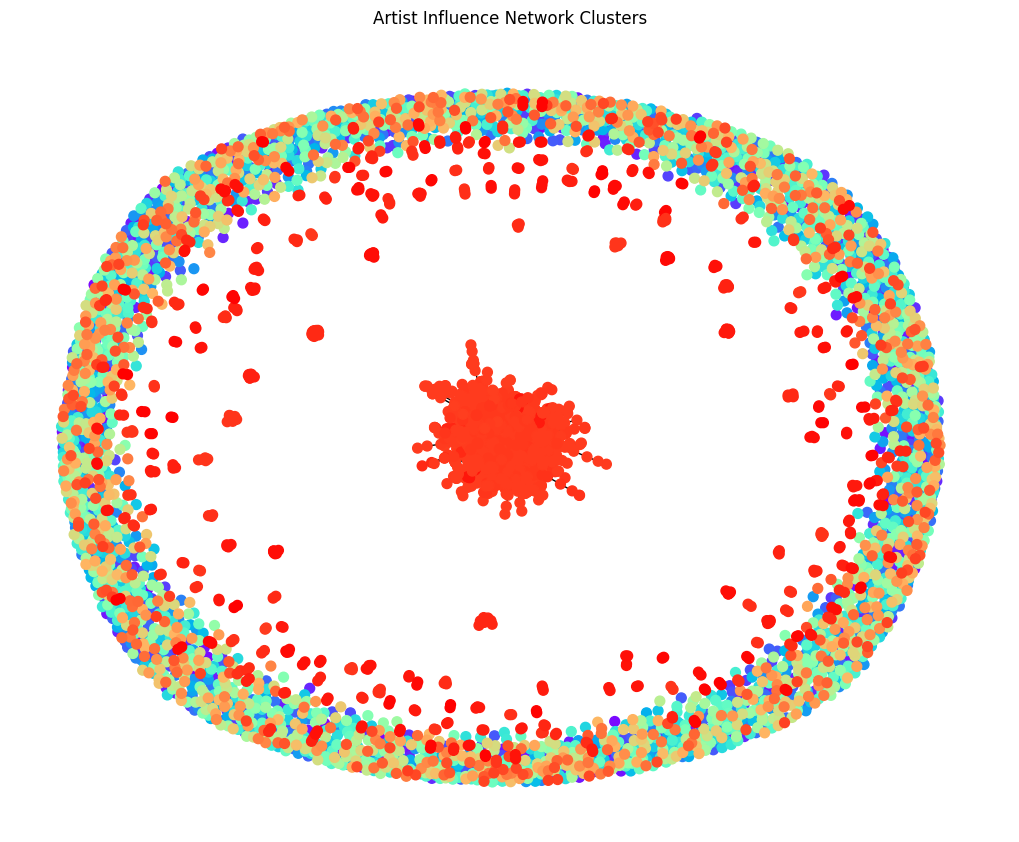

In [258]:
# Assign colors to clusters based on Louvain algorithm results
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization

# Color nodes by community
colors = [louvain_clusters[node] for node in G.nodes()]
nx.draw(G, pos, node_color=colors, with_labels=False, cmap=plt.cm.rainbow, node_size=50, font_size=8)

plt.title("Artist Influence Network Clusters")
plt.show()


In [255]:
from networkx.algorithms.community import k_clique_communities

# Apply k-clique communities (choose k=3 for triads or stronger for tighter groups)
k = 3
clique_communities = list(k_clique_communities(G, k))
for i, community in enumerate(clique_communities):
    print(f"Clique Community {i}: {community}")

Clique Community 0: frozenset({'joshua-reynolds', 'marjorie-acker-phillips', 'fernand-leger', 'john-constable', 'eugene-delacroix', 'expressionism', 'school_/en/artists-by-painting-school/english-school', 'johannes-vermeer', 'jackson-pollock', 'constantin-brancusi', 'thomas-gainsborough', 'anton-raphael-mengs', 'robert-delaunay', 'morris-louis', 'max-ernst', 'david-alfaro-siqueiros', 'graham-sutherland', 'ilya-repin', 'rembrandt', 'giovanni-battista-tiepolo', 'mikhail-larionov', 'john-singer-sargent', 'damien-hirst', 'frans-hals', 'wassily-kandinsky', 'oleksandr-murashko', 'adam-elsheimer', 'camille-corot', 'institution_/en/artists-by-art-institution/akademie-der', 'diego-velazquez', 'francis-bacon', 'caravaggio', 'school_/en/artists-by-painting-school/venetian-school', 'marc-chagall', 'giovanni-battista-salvi-da-sassoferrato', 'abstract-expressionism', 'vilhelm-lundstrom', 'bernard-van-orley', 'charles-francois-daubigny', 'edvard-munch', 'parmigianino', 'frank-w-benson', 'giorgio-de-c